In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math

from typing import Iterable, Iterator, TypeVar, Callable, Mapping, Tuple
from rl.distribution import Categorical
from rl.iterate import last
from rl.markov_decision_process import MarkovDecisionProcess, Policy, TransitionStep, NonTerminal
from rl.policy import DeterministicPolicy, RandomPolicy, UniformPolicy
import rl.markov_process as mp
from rl.markov_process import MarkovRewardProcess
from rl.returns import returns
import itertools

In [14]:
from rl.chapter2.simple_inventory_mrp import SimpleInventoryMRPFinite
from rl.chapter2.simple_inventory_mrp import InventoryState
from rl.distribution import Choose
from rl.iterate import last
from itertools import islice
from pprint import pprint
import itertools

### TD($\lambda$) Prediction Algorithm

#### Tabular case

In [28]:
S = TypeVar('S')
def tabular_td_lambda_prediction(
    mrp: MarkovRewardProcess[S],
    traces: Iterable[Iterable[Tuple[NonTerminal[S], float, NonTerminal[S]]]],
    gamma: float,
    lambda_: float,
    alpha_func: Callable[[int], float]
) -> Mapping[NonTerminal[S], float]:
    count: Mapping[NonTerminal[S], int] = {s: 0 for s in mrp.non_terminal_states}
    value_function: Mapping[NonTerminal[S], float] = {s: 0.0 for s in mrp.non_terminal_states}
    for trace in traces:
        E: Mapping[NonTerminal[S], int] = {s: 0 for s in mrp.non_terminal_states}
        for state_pair in trace:
            state, reward, next_state = state_pair
            count[state] += 1
            n = count[state]
            alpha = alpha_func(n)
            for each_state in mrp.non_terminal_states:
                E[each_state] = gamma * lambda_ * E[each_state]
            E[state] = E[state] + 1
            
            delta = reward + gamma * value_function[next_state] - value_function[state]
            for each_state in mrp.non_terminal_states:
                value_function[each_state] = value_function[each_state] + alpha * delta * E[each_state]
                            
    return value_function

##### method 2 + test

In [11]:
def tabular_td_lambda_prediction_2(states_rewards, v0: dict, gamma, lambda_, alph = 0.03, beta = 0.5, H = 1000):
    lr = lambda n: alph / (1+((n-1)/H)**beta)
    v = v0
    E = v.copy()
    n = 1
    for state_reward in states_rewards:
        state = state_reward.state
        next_state = state_reward.next_state
        reward = state_reward.reward
        E = {s: gamma * lambda_ * E[s] for s in E.keys()}
        E[state] = E[state] + 1
        v = {s: v[s] + lr(n) * (reward + gamma * v[next_state] - v[state]) * E[s] for s in v.keys()}
        n = n + 1
        yield v

In [27]:
from rl.distribution import Constant
states = si_mrp.non_terminal_states
v0 = {state:0 for state in states}
user_lambda = 0.5
init_dist = Constant(si_mrp.non_terminal_states[0])
tabular_td_lambda = tabular_td_lambda_prediction_2(si_mrp.simulate_reward(init_dist), 
                                                   v0, user_gamma, user_lambda)
for i in range (20000):
    v = next(tabular_td_lambda)
for key in v.keys():
    print(key, v[key])

NonTerminal(state=InventoryState(on_hand=0, on_order=0)) -35.33075609399342
NonTerminal(state=InventoryState(on_hand=0, on_order=1)) -27.888229374206293
NonTerminal(state=InventoryState(on_hand=0, on_order=2)) -28.27592896877164
NonTerminal(state=InventoryState(on_hand=1, on_order=0)) -28.730177198909296
NonTerminal(state=InventoryState(on_hand=1, on_order=1)) -29.213796715963436
NonTerminal(state=InventoryState(on_hand=2, on_order=0)) -30.10234495640545


#### Function approximation case

In [29]:
import rl.markov_process as mp
import numpy as np
from rl.function_approx import Gradient
from rl.approximate_dynamic_programming import ValueFunctionApprox
def td_lambda_prediction(
    traces: Iterable[Iterable[mp.TransitionStep[S]]],
    approx_0: ValueFunctionApprox[S],
    gamma: float,
    lambd: float
) -> Iterator[ValueFunctionApprox[S]]:
    func_approx: ValueFunctionApprox[S] = approx_0
    yield func_approx
    
    for trace in traces:
        el_tr: Gradient[ValueFunctionApprox[S]] = Gradient(func_approx).zero()
        for step in trace:
            x: NonTerminal[S] = step.state
            y: float = step.reward + gamma * extended_vf(func_approx, step.next_state)
            el_tr = el_tr * (gamma * lambd) + func_approx.objective_gradient(
                xy_vals_seq=[(x, y)],
                obj_deriv_out_fun=lambda x1, y1: np.ones(len(x1))
            )
            func_approx = func_approx.update_with_gradient(
                el_tr * (func_approx(x) - y)
            )
            yield func_approx


### Test on SimpleInventory MRPFinite

In [12]:
# exact value
user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0
user_gamma = 0.9
si_mrp: SimpleInventoryMRPFinite = SimpleInventoryMRPFinite(
    capacity = user_capacity,
    poisson_lambda = user_poisson_lambda,
    holding_cost = user_holding_cost,
    stockout_cost = user_stockout_cost
)
si_mrp.display_value_function(gamma=user_gamma)

{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.345,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.511,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.932,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.932,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.345,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.345}


In [31]:
episodes_num = 600
episode_length: int = 100
initial_learning_rate: float = 0.03
half_life: float = 1000.0
exponent: float = 0.5
gamma: float = 0.9
lambda_: float = 0.3
from rl.function_approx import learning_rate_schedule

In [32]:
# tabular_TD(lambda)
def episode(
    mrp: MarkovRewardProcess[S],
    episode_length: int 
):
    start_state_distribution = Choose(si_mrp.non_terminal_states)
    state: State[S] = start_state_distribution.sample()
    state_reward_pair = []; 
    for i in range (episode_length):
        next_distribution = mrp.transition_reward(state)
        next_state, reward = next_distribution.sample()
        state_reward_pair.append((state,reward,next_state))
        state = next_state  
    return state_reward_pair 

episodes = []
for i in range (episodes_num):
    episodes.append(episode(si_mrp, episode_length))

tabular_td_lambda_prediction(si_mrp, episodes, gamma, lambda_, learning_rate_schedule(initial_learning_rate, half_life, exponent))

{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.7169744381034,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -28.231815619744253,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.629587626375613,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -29.17984586877161,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.70166405083645,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.753931169658532}

In [33]:
# function_approximation_TD(lambda)
from rl.chapter10.prediction_utils import fmrp_episodes_stream
from rl.function_approx import Tabular
import rl.iterate as iterate
from rl.approximate_dynamic_programming import extended_vf

episodes = si_mrp.reward_traces(Choose(si_mrp.non_terminal_states))
curtailed_episodes = (itertools.islice(episode, episode_length) for episode in episodes)
learning_rate_func: Callable[[int], float] = learning_rate_schedule(
    initial_learning_rate=initial_learning_rate,
    half_life=half_life,
    exponent=exponent
)
td_lambda_vfs = td_lambda_prediction(
    traces = curtailed_episodes,
    approx_0 = Tabular(count_to_weight_func=learning_rate_func), gamma=gamma, lambd=lambda_
)

final_td_lambda_vf: ValueFunctionApprox[S] = \
iterate.last(itertools.islice(td_lambda_vfs, episode_length * episodes_num))
pprint({s: round(final_td_lambda_vf(s), 3) for s in si_mrp.non_terminal_states})

{NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.674,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.401,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -27.968,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -29.775,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -28.987,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.51}


#### Plot graphs for convergence of different lambda

We plotted the RMSE of the value function after each batch of 10 episodes for TD(0), TD(0.2), TD(0.4), TD(0.6), TD(0.8) and TD(1.0)

In [100]:
batch_size = 50
batch_num = 100
iterator_value_func = np.zeros((batch_num, len(si_mrp.get_value_function_vec(gamma))))

In [101]:
def RMSE(x,y):
    return np.sqrt(sum(((x-y)**2)))

true_value = si_mrp.get_value_function_vec(gamma)
RMSE_mat = np.zeros((6, batch_num))
for l in range (6):
    lambda_ = 0.2 * l
    approx_0 = Tabular(count_to_weight_func=learning_rate_func)
    for i in range (batch_num):
        td_lambda_vfs = td_lambda_prediction(
            traces = curtailed_episodes,
            approx_0 = approx_0, gamma=gamma, lambd=lambda_
        )
        final_td_lambda_vf: ValueFunctionApprox[S] = iterate.last(itertools.islice(td_lambda_vfs, episode_length * batch_size))
        approx_0 = final_td_lambda_vf
        state_order = 0
        for s in si_mrp.non_terminal_states:
            iterator_value_func[i,state_order] = round(final_td_lambda_vf(s), 3)
            state_order += 1
    
    for i in range (batch_num):
        RMSE_mat[l,i] = RMSE(true_value, iterator_value_func[i,:])

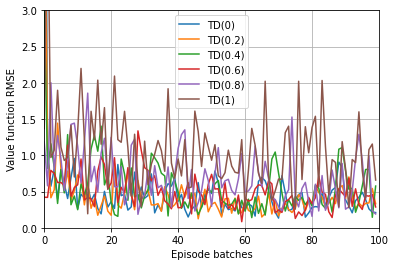

In [102]:
x = np.arange(batch_num)
# Plotting the Graph
plt.plot(x,RMSE_mat[0,:])
plt.plot(x,RMSE_mat[1,:])
plt.plot(x,RMSE_mat[2,:])
plt.plot(x,RMSE_mat[3,:])
plt.plot(x,RMSE_mat[4,:])
plt.plot(x,RMSE_mat[5,:])

plt.ylabel("Value function RMSE")
plt.xlabel("Episode batches")
plt.xlim([0,100])
plt.ylim([0,3])
plt.grid()
plt.legend(["TD(0)","TD(0.2)","TD(0.4)","TD(0.6)","TD(0.8)","TD(1)"])
#plt.savefig("./result/RMSE_random_differentN.png",dpi = 500)
plt.show()

Note that two special cases of TD algorithm are: TD(0) is TD and TD(1) is every-visit MC
MC RMSE curve is choppy and has more variance.TD($\lambda$) with $\lambda$ close to 0 can reach relatively small RMSE with few episode batchs, quicker than TD($\lambda$) with $\lambda$ close to 1. Additionally, TD(